In [3]:
__date__   = 4/4/2018
__author__ = "Alok Singh"

In [4]:
# Paper: https://arxiv.org/pdf/0710.3742v1.pdf

In [5]:
import pickle
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import graphlab as gl

In [6]:
os.getcwd()
os.chdir("/datavol2/bnl_dataframes/csvs")
os.getcwd()

init  = True
sf    = None
itera = 0

for file in glob.glob("ee*.json.df.csv"):
    itera += 1
    #
    if init:
        #first call
        sf = gl.SFrame.read_csv(file, verbose=False)
        init = False
    else:
        sf = sf.append(gl.SFrame.read_csv(file, verbose=False))
    #
    print(itera, " File : ", file, "| Size > ", sf.num_cols(), sf.num_rows())
    
    if itera > 200:
        break

This non-commercial license of GraphLab Create for academic use is assigned to a1singh@eng.ucsd.edu and will expire on February 23, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1523308362.log


(1, ' File : ', 'ee-test-for-ml-lammps-128+128.3755465.0.json.df.csv', '| Size > ', 6, 173033)
(2, ' File : ', 'ee-test-for-ml-lammps-128+128.3755465.1.json.df.csv', '| Size > ', 6, 344592)
(3, ' File : ', 'ee-test-for-ml-lammps-128+128.3755465.10.json.df.csv', '| Size > ', 6, 515392)
(4, ' File : ', 'ee-test-for-ml-lammps-128+128.3755465.100.json.df.csv', '| Size > ', 6, 689818)
(5, ' File : ', 'ee-test-for-ml-lammps-128+128.3755465.101.json.df.csv', '| Size > ', 6, 863388)
(6, ' File : ', 'ee-test-for-ml-lammps-128+128.3755465.102.json.df.csv', '| Size > ', 6, 1036022)
(7, ' File : ', 'ee-test-for-ml-lammps-128+128.3755465.103.json.df.csv', '| Size > ', 6, 1203746)
(8, ' File : ', 'ee-test-for-ml-lammps-128+128.3755465.104.json.df.csv', '| Size > ', 6, 1375310)
(9, ' File : ', 'ee-test-for-ml-lammps-128+128.3755465.105.json.df.csv', '| Size > ', 6, 1547419)
(10, ' File : ', 'ee-test-for-ml-lammps-128+128.3755465.106.json.df.csv', '| Size > ', 6, 1718044)
(11, ' File : ', 'ee-test-for

In [7]:
print(sf.num_cols(), sf.num_rows())

(6, 34719254)


In [11]:
sf.head(1)

X1,kl,time_by_lasttime,time_diff,node_id,thread_id
0,.TAUapplication:MPI_Init() ...,1.06032750438e-05,55893.0,0,0


In [12]:
import graphlab.aggregate as agg
ngram_count = sf.groupby(key_columns='kl', operations={'numberofcalls': agg.COUNT()})

In [13]:
ngram_count = ngram_count.sort('numberofcalls', ascending = False)
ngram_count.print_rows(max_column_width=60)

+-------------------------------------------------------------+---------------+
|                              kl                             | numberofcalls |
+-------------------------------------------------------------+---------------+
| voidLAMMPS_NS::Run::command(int,char**):voidLAMMPS_NS::V... |    3062943    |
| voidLAMMPS_NS::Run::command(int,char**):voidLAMMPS_NS::V... |    3062943    |
| voidLAMMPS_NS::Run::command(int,char**):voidLAMMPS_NS::V... |    3062943    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::... |    3055707    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::... |    3055707    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::... |    3055707    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::... |    1591920    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::... |    1591920    |
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::... |    1591920    |
| voidLAMMPS_NS::Run::command(int,char**

In [17]:
# Define max and min threshold
minn = 1600000
maxx = 10*minn                      #float("inf")

subset = ngram_count[(ngram_count['numberofcalls'] > minn) & (ngram_count['numberofcalls'] < maxx)]
freq   = subset.sample(0.1)

mul=0.01
while (len(freq) < 1 and mul<1):
    freq   = subset.sample(mul)
    mul    *= 5
    
    
freq.print_rows(max_column_width=60)

+-------------------------------------------------------------+---------------+
|                              kl                             | numberofcalls |
+-------------------------------------------------------------+---------------+
| voidLAMMPS_NS::Verlet::run(int):voidLAMMPS_NS::PairEAM::... |    3055707    |
+-------------------------------------------------------------+---------------+
[1 rows x 2 columns]



In [20]:
def perform_bayesiancp(sf, thetitle, frac, erunlen=3, inputlag=3):
    import numpy as np
    import matplotlib.pyplot as plt
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15.5, 10.5)
    
    #Prune extreme outliers
    prune   = 100000
    howmany = 1
    
    while (len(sf[sf['time_diff']>prune]) > 10):
        prune   += 50000
        howmany += 1
        if(howmany > 100):
            print('Break')
            break
    
    sf = sf[sf['time_diff']<prune]
    
    # sort by time
    sf = sf.sort('time_by_lasttime', ascending = True)
    #print('Checkpoint 1 Sorted')
    
    model = gl.anomaly_detection.bayesian_changepoints.create(sf, feature = 'time_diff', 
                                                              expected_runlength = erunlen, 
                                                              lag = inputlag)
    
    #model['scores'].print_rows(max_column_width=100)
    
    scores = model['scores']['changepoint_score']
    
    #print('Checkpoint 2')
    
    thresh = 0.1
    # Select the threshold value
    howmany = 1
    while (len(scores[scores>thresh]) > frac*len(scores) and thresh<=.99):
        thresh  += .001
        howmany += 1
    
    print("Threshold = %.4f, #Anomalies=%d, Total #Datapoints=%d" % (thresh, len(scores[scores>thresh]), len(scores)))
    
    plt.title("Bayesian Changepoints; function: " + str(thetitle))
    
    # Method 1
    #print('Checkpoint 3')
    df_outliers   = model['scores'][model['scores']['changepoint_score'] > thresh]
    time_outliers = sf[model['scores']['changepoint_score'] > thresh]['time_by_lasttime']
    
    #print('Checkpoint 4')
    df_normals   = model['scores'][model['scores']['changepoint_score'] <= thresh]
    time_normals = sf[model['scores']['changepoint_score'] <= thresh]['time_by_lasttime']
    
    # Plot
    #print('Checkpoint 5')
    g = plt.scatter(time_normals ,  df_normals['time_diff'], c='green', s=65, edgecolor='k')
    h = plt.scatter(time_outliers, df_outliers['time_diff'], c='red', s=65, edgecolor='k')
    
    # Adjust Plot
    minx=sf['time_by_lasttime'].min()
    maxx=sf['time_by_lasttime'].max()
    miny=sf['time_diff'].min()
    maxy=sf['time_diff'].max()
    
    plt.axis('tight')
    plt.xlim((minx, maxx))
    plt.ylim((miny, maxy))
    plt.legend([g, h],["Normal","Outliers"],loc="upper right")
    plt.show()

Threshold = 0.8850, #Anomalies=271, Total #Datapoints=3055707


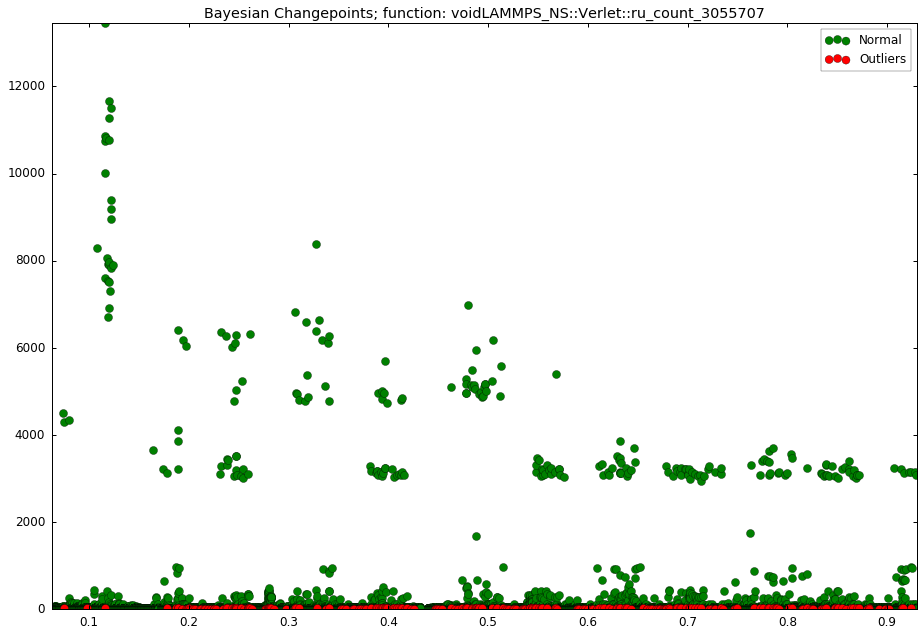

CPU times: user 23min 12s, sys: 17min 49s, total: 41min 2s
Wall time: 13min 25s


In [19]:
%%time

sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

for i in range(len(freq)):
    pick_func = freq[i]['kl']
    count     = freq[i]['numberofcalls']
    lbl       = str(pick_func)[:25] +'_count_'+ str(count)
    
    perform_bayesiancp(sf[sf['kl'] == pick_func], thetitle=lbl, frac=0.0001, erunlen=3, inputlag=3)

Threshold = 0.9900, #Anomalies=3055707, Total #Datapoints=3055707


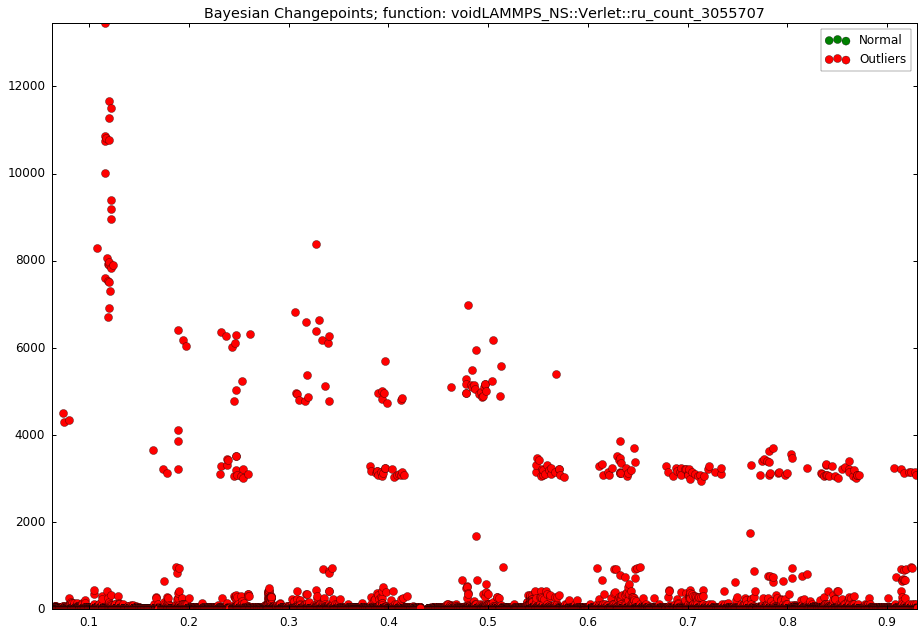

CPU times: user 20min 58s, sys: 9min 18s, total: 30min 16s
Wall time: 12min 59s


In [21]:
%%time

sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

for i in range(len(freq)):
    pick_func = freq[i]['kl']
    count     = freq[i]['numberofcalls']
    lbl       = str(pick_func)[:25] +'_count_'+ str(count)
    
    perform_bayesiancp(sf[sf['kl'] == pick_func], thetitle=lbl, frac=0.0001, erunlen=1, inputlag=0)

Threshold = 0.9900, #Anomalies=644, Total #Datapoints=3055707


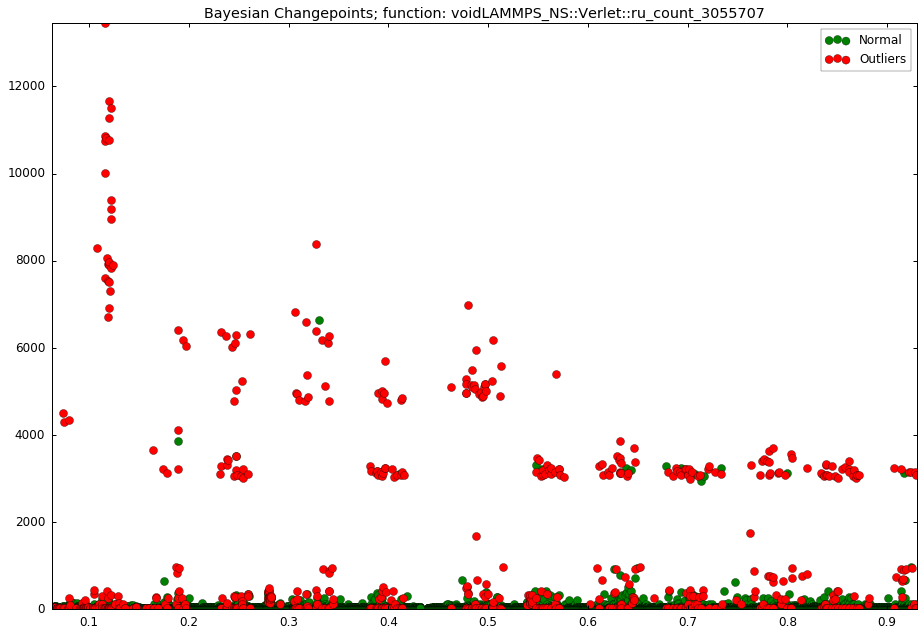

CPU times: user 23min 31s, sys: 12min 10s, total: 35min 41s
Wall time: 13min 2s


In [22]:
%%time

sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

for i in range(len(freq)):
    pick_func = freq[i]['kl']
    count     = freq[i]['numberofcalls']
    lbl       = str(pick_func)[:25] +'_count_'+ str(count)
    
    perform_bayesiancp(sf[sf['kl'] == pick_func], thetitle=lbl, frac=0.0001, erunlen=2, inputlag=0)

In [ ]:
#################################################################
#################################################################